In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/m1m2_cut`


h_plot (generic function with 1 method)

In [2]:
## Output Directory for Plots
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 23
yticklabelsize = 23
titlesize = 35
draws = 500

plot_save = true

true

# Load Traces

In [3]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.25, minimum Neff_sel = 1801.0, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sdnNjb2RlLXJlbW90ZQ==.jl:4


In [4]:
trace_samples_0p1 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.1.nc"))
ne_min = dropdims(minimum(trace_samples_0p1.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p1.posterior.Neff_sel)
@info "p_cut = 0.1, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p1.posterior, :event)))"

┌ Info: p_cut = 0.1, minimum Neff_samps: 4.19, minimum Neff_sel = 1277.8, 4*Nobs = 220
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sdnNjb2RlLXJlbW90ZQ==.jl:4


In [5]:
trace_samples_0p9 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p9.posterior.Neff_sel)
@info "p_cut = 0.9, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p9.posterior, :event)))"

┌ Info: p_cut = 0.9, minimum Neff_samps: 4.25, minimum Neff_sel = 894.4, 4*Nobs = 176
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:4


## Compare Marginal $m_1$ with $p_{\mathrm{cut}}$

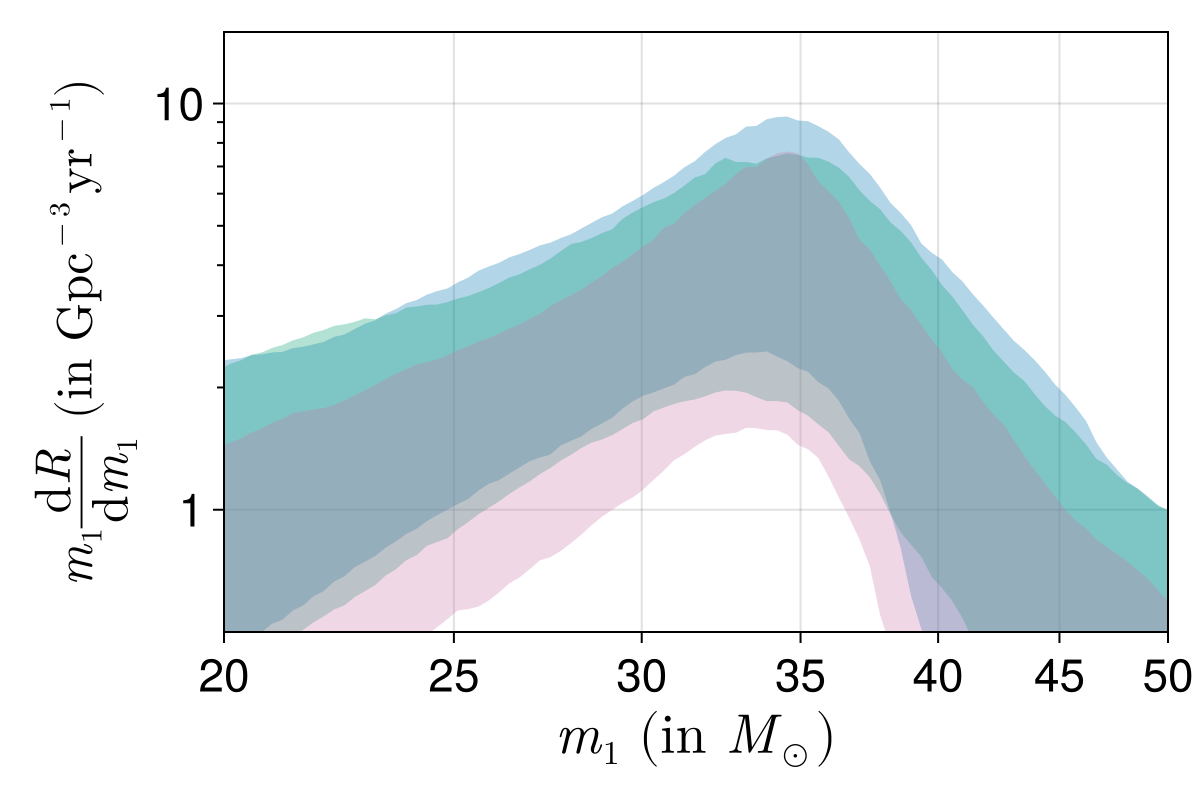

In [6]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max))
qs=0.001:0.01:1
draws=draws
rng=Random.default_rng()
colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green


f = Figure(size=(600, 400))
a = Axis(f[1,1],
    xlabel = L"m_1~(\mathrm{in~}M_\odot)",
    ylabel = L"m_1 \frac{\mathrm{d} R}{\mathrm{d} m_1}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    xscale = log10, yscale = log10,
    xticks = [20, 25, 30, 35, 40, 45, 50], xtickformat = "{:.0f}",
    yticks = [1, 10, 100], yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], yminorticksvisible = true, ytickformat = "{:.0f}",
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = (20.0, 50.0, 0.5, 15.0)
)

# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")

if plot_save
    save(outdir * "appen_pcut_m1_marginal.pdf", f, px_per_unit=3)
end
f

## Compare Marginal $q$ with $p_{\mathrm{cut}}$

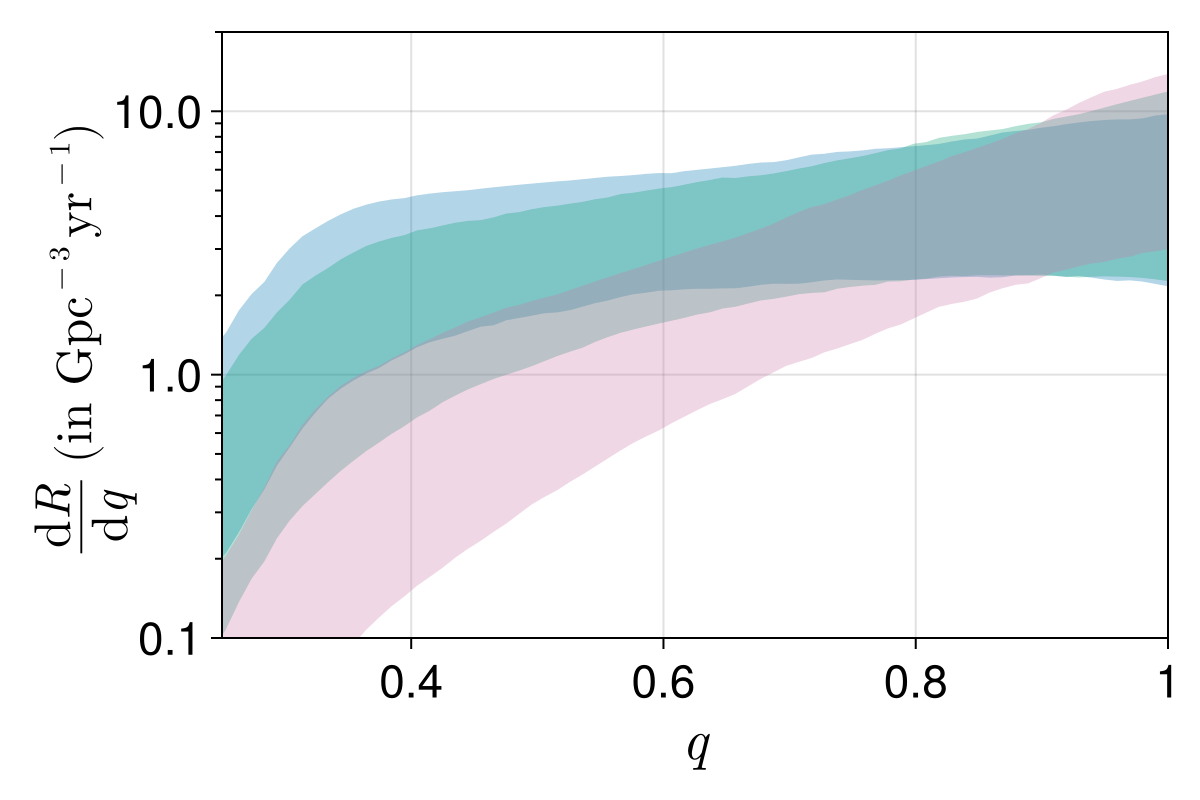

In [7]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max)) 
qs=collect(range(0.001, stop=1.0, length=100)) 
draws=draws
rng=Random.default_rng()
limits=(0.25, 1, 0.1, 20)
yticks=[0.1, 1, 10, 100]
yminorticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]
colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green


f = Figure(size=(600, 400))
    
a = Axis(f[1,1],
    xlabel = L"q",
    ylabel = L"\frac{\mathrm{d} R}{\mathrm{d} q}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    yscale = log10,
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    ytickformat = "{:.1f}",
    xtickformat = xs -> map(x -> isinteger(x) ? string(Int(x)) : string(round(x; digits=2)), xs),
    xticks = vcat(0.0:0.2:0.8, 1.0),
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = limits
)



# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")
a.ylabelpadding[] = -12
if plot_save
    save(outdir * "appen_pcut_q_marginal.pdf", f, px_per_unit=3)
end
f

## Compare Marginal $\chi_{\mathrm{eff}}$ with $p_{\mathrm{cut}}$

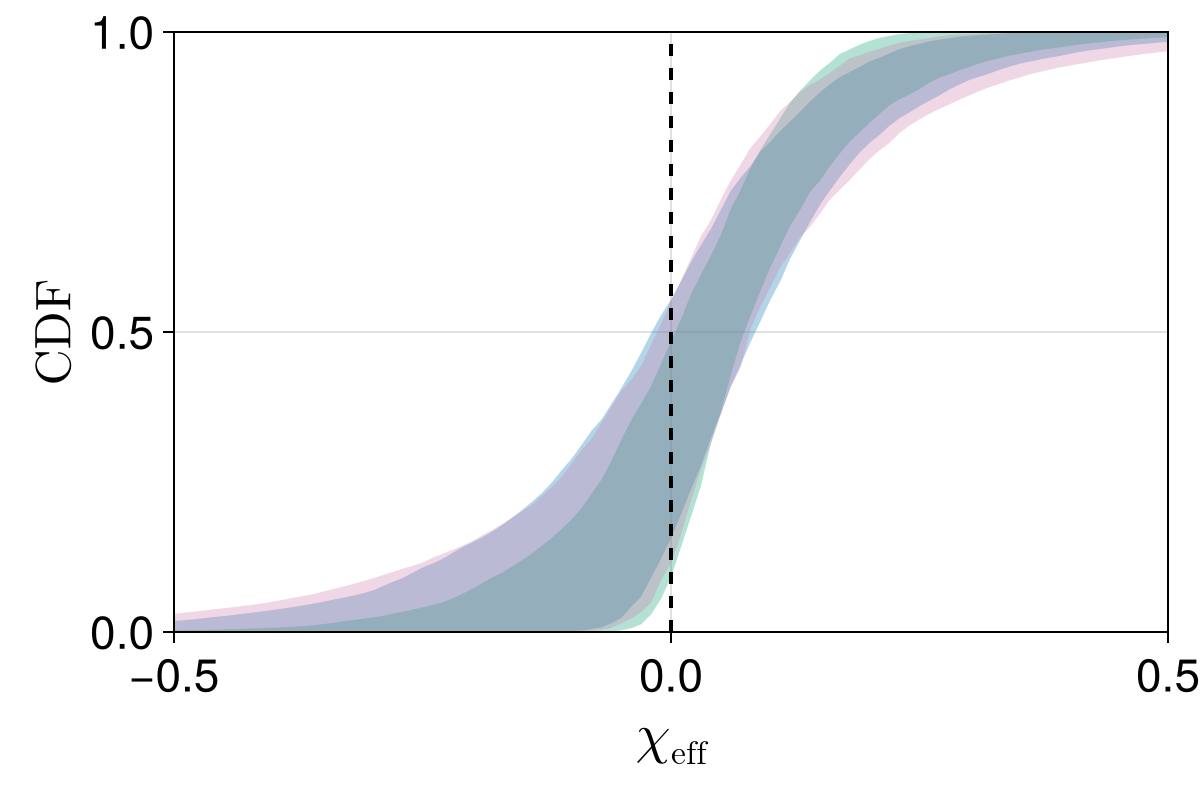

In [8]:
z_plot = 0.0
chi_effs = collect(-1.0:0.01:1.0)
qs = collect(0.01:0.01:1.0)
ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100))
draws = draws

colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\chi_\mathrm{eff}",
    ylabel=L"\mathrm{CDF}",
    xlabelsize=28, ylabelsize=25,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    xgridvisible=true, ygridvisible=true,
    limits = (-0.5, 0.5, 0.0, 1.0)
)

dchi_eff = chi_effs[2] - chi_effs[1]

# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.10), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.90), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")
vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
if plot_save
    save(outdir * "appen_pcut_chieff_marginal.pdf", fig, px_per_unit=3)
end
fig

## Compare Marginal $z$ with $p_{\mathrm{cut}}$

In [9]:
# To Create Normalization
function load_GWTC3_population_data(filepath::String)
    h5open(filepath, "r") do file
        z_GWTC3 = read(file["zs"])
        Rz_med = read(file["Rz_med"])

        return (; z_GWTC3, Rz_med)
    end
end

z_GWTC3, Rz_med = load_GWTC3_population_data("../data/GWTC3_PLPP.h5")

(z_GWTC3 = [0.0, 0.015151515151515152, 0.030303030303030304, 0.045454545454545456, 0.06060606060606061, 0.07575757575757576, 0.09090909090909091, 0.10606060606060606, 0.12121212121212122, 0.13636363636363635  …  1.3636363636363638, 1.378787878787879, 1.393939393939394, 1.4090909090909092, 1.4242424242424243, 1.4393939393939394, 1.4545454545454546, 1.4696969696969697, 1.4848484848484849, 1.5], Rz_med = [16.757602661221213, 17.463131006300046, 18.174050453682426, 18.955633360782024, 19.793907639223253, 20.65612010871525, 21.379610852340782, 22.332608491595046, 23.263793656668902, 24.19998287080528  …  207.8875293905552, 212.05486860365863, 216.09393782376483, 219.72578049837784, 223.50743163234466, 227.43987219247452, 231.64365527461206, 235.9980239139351, 240.18617381749644, 244.42252961780588])

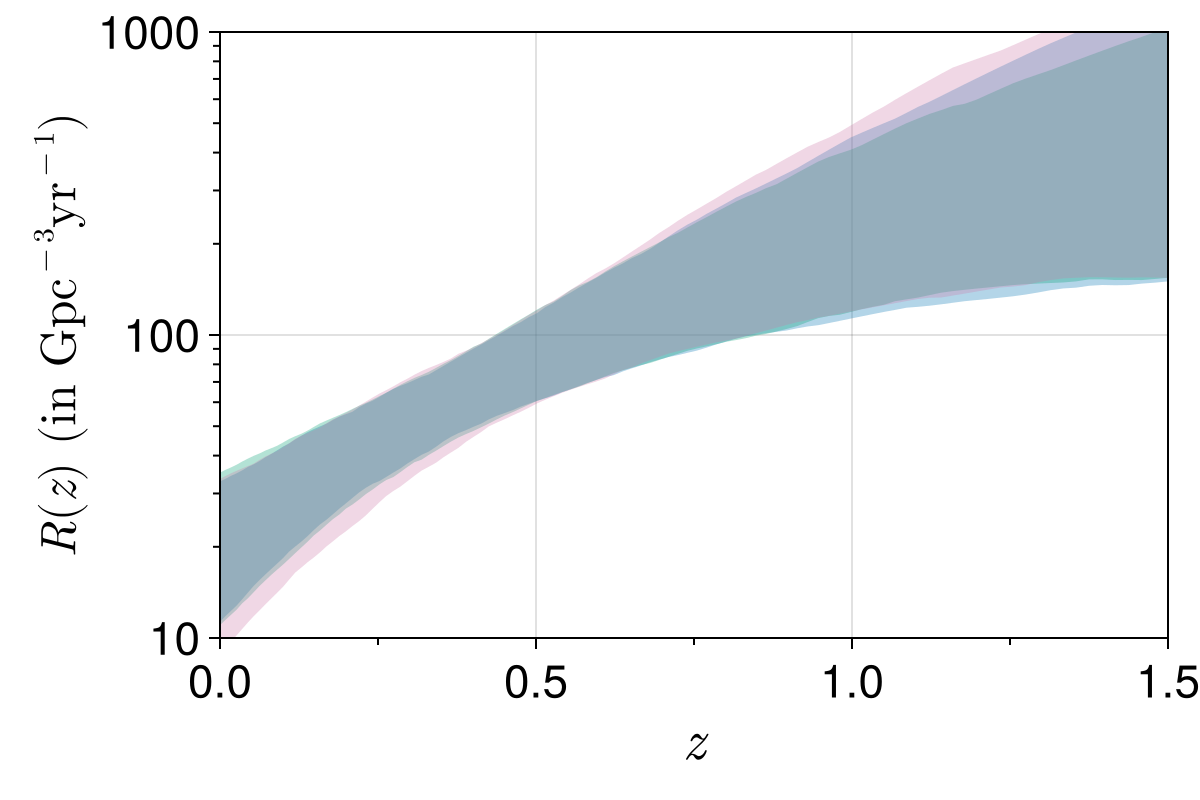

In [10]:
ms = exp.(log(m_bh_min):0.01:log(m_bh_max))
qs = 0.001:0.01:1
zs = expm1.(range(log(1), stop=log(1 + 2), length=128))
draws = draws
rng = Random.default_rng()
limits = (0, 1.5, 10, 1000)
yticks = [1, 10, 100, 1000]
yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900]

f = Figure(size=(600, 400))
a = Axis(f[1, 1],
    xlabel = L"z",
    ylabel = L"R(z)~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})",
    yscale = log10,
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    ytickformat = "{:.0f}",
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    xminorticksvisible = true,
    limits = limits
)

colors = Makie.wong_colors()
color_01 = colors[1]  # blue
color_05 = colors[3]  # orange
color_09 = colors[4]  # green

# Plot pcut=0.1
trace = trace_samples_0p1
p = trace.posterior
dNs = zeros(length(zs), draws)

@progress for j in 1:draws
    c = rand(rng, span(dims(p, :chain)))
    d = rand(rng, span(dims(p, :draw)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    z1 = zs[1]
    dNdms = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
            end
        end
        trapz(qs, integrand)
    end

    norm = trace.posterior.R[draw=d, chain=c] *
            trapz(ms, dNdms) /
            exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

    dNdz = map(zs) do z
        norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
    end

    dNs[:, j] = dNdz
end

medians = mapslices(median, dNs; dims=2)[:]
lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

vs = vec(var(log.(dNs), dims=2))
imin = argmin(vs)
norm = Rz_med[imin]

band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(color_01, 0.3), label=L"p_{\mathrm{cut}}=0.1")

# Plot pcut=0.5
trace = trace_samples_0p5
p = trace.posterior
dNs = zeros(length(zs), draws)

@progress for j in 1:draws
    c = rand(rng, span(dims(p, :chain)))
    d = rand(rng, span(dims(p, :draw)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    z1 = zs[1]
    dNdms = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
            end
        end
        trapz(qs, integrand)
    end

    norm = trace.posterior.R[draw=d, chain=c] *
            trapz(ms, dNdms) /
            exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

    dNdz = map(zs) do z
        norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
    end

    dNs[:, j] = dNdz
end

medians = mapslices(median, dNs; dims=2)[:]
lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

vs = vec(var(log.(dNs), dims=2))
imin = argmin(vs)
norm = Rz_med[imin]

band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(color_05, 0.3), label=L"p_{\mathrm{cut}}=0.5")

# Plot pcut=0.9
trace = trace_samples_0p9
p = trace.posterior
dNs = zeros(length(zs), draws)

@progress for j in 1:draws
    c = rand(rng, span(dims(p, :chain)))
    d = rand(rng, span(dims(p, :draw)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    z1 = zs[1]
    dNdms = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
            end
        end
        trapz(qs, integrand)
    end

    norm = trace.posterior.R[draw=d, chain=c] *
            trapz(ms, dNdms) /
            exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

    dNdz = map(zs) do z
        norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
    end

    dNs[:, j] = dNdz
end

medians = mapslices(median, dNs; dims=2)[:]
lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

vs = vec(var(log.(dNs), dims=2))
imin = argmin(vs)
norm = Rz_med[imin]

band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(color_09, 0.3), label=L"p_{\mathrm{cut}}=0.9")

if plot_save
    save(outdir * "appen_pcut_z_marginal.pdf", f, px_per_unit=3)
end
f

## Compare with Mc Cut

In [11]:
trace_m1m2 = trace_samples_0p5

InferenceData with groups:
  > posterior
  > sample_stats

In [12]:
trace_Mc = from_netcdf("/mnt/home/sroy1/35Msun_GWTC3/Mc_cut/data/chains_0.5.nc")
ne_min = dropdims(minimum(trace_Mc.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_Mc.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_Mc.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.29, minimum Neff_sel = 919.9, 4*Nobs = 172
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sdnNjb2RlLXJlbW90ZQ==.jl:4


## Marginal $m_1$

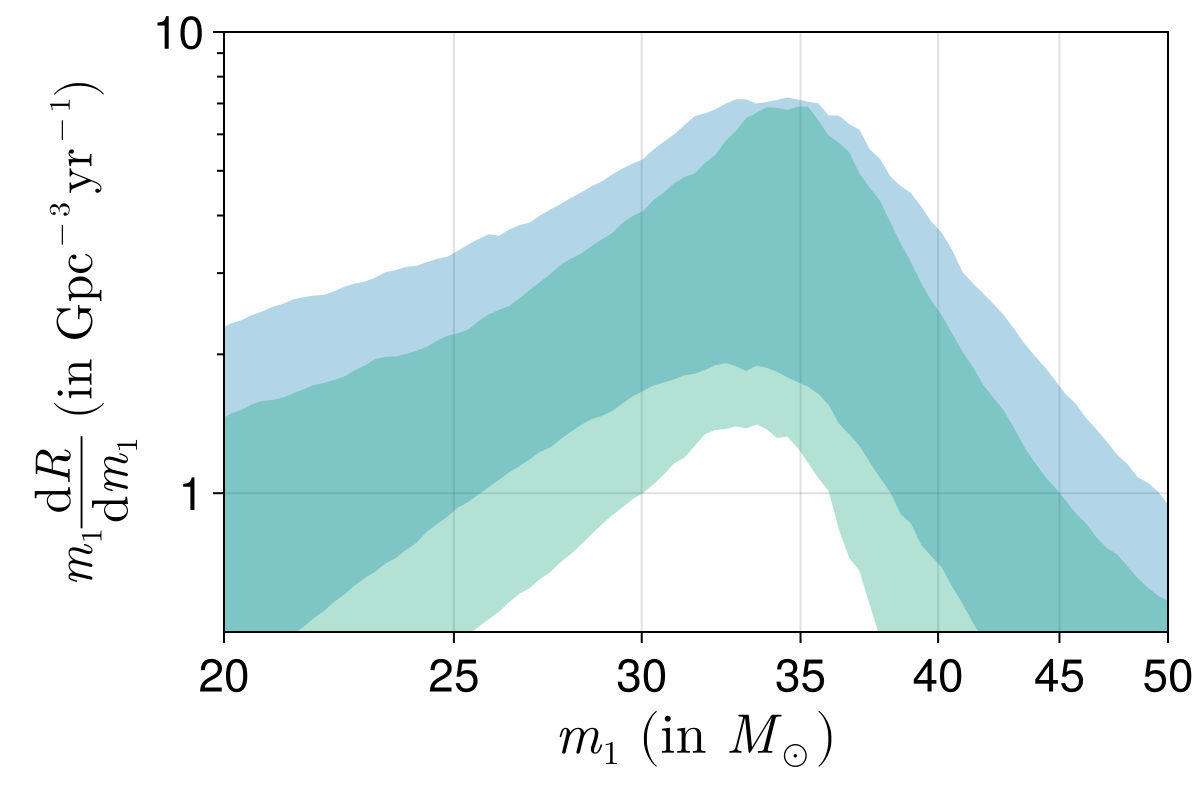

In [13]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max))
qs=0.001:0.01:1
draws=draws
rng=Random.default_rng()
colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_Mc = colors[3]


f = Figure(size=(600, 400))
a = Axis(f[1,1],
    xlabel = L"m_1~(\mathrm{in~}M_\odot)",
    ylabel = L"m_1 \frac{\mathrm{d} R}{\mathrm{d} m_1}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    xscale = log10, yscale = log10,
    xticks = [20, 25, 30, 35, 40, 45, 50], xtickformat = "{:.0f}",
    yticks = [1, 10, 100], yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], yminorticksvisible = true, ytickformat = "{:.0f}",
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = (20.0, 50.0, 0.5, 10.0)
)

# Plot m1-m2 Cut
trace = trace_m1m2
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_m1m2, 0.3), label=L"m_1-m_2~\mathrm{Cut}")

# Plot Mc Cut
trace = trace_Mc
p = trace.posterior
dNdm1_matrix = zeros(length(ms), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, 1:length(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdm1 = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        m * p.R[chain=c, draw=d] * trapz(qs, integrand)
    end

    dNdm1_matrix[:, i] = dNdm1
end

q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

band!(a, ms, q5, q95, color=(color_Mc, 0.3), label=L"M_c~\mathrm{Cut}")

if plot_save
    save(outdir * "appen_diff_mcut_m1_marginal.pdf", f, px_per_unit=3)
end
f

## Marginal $q$

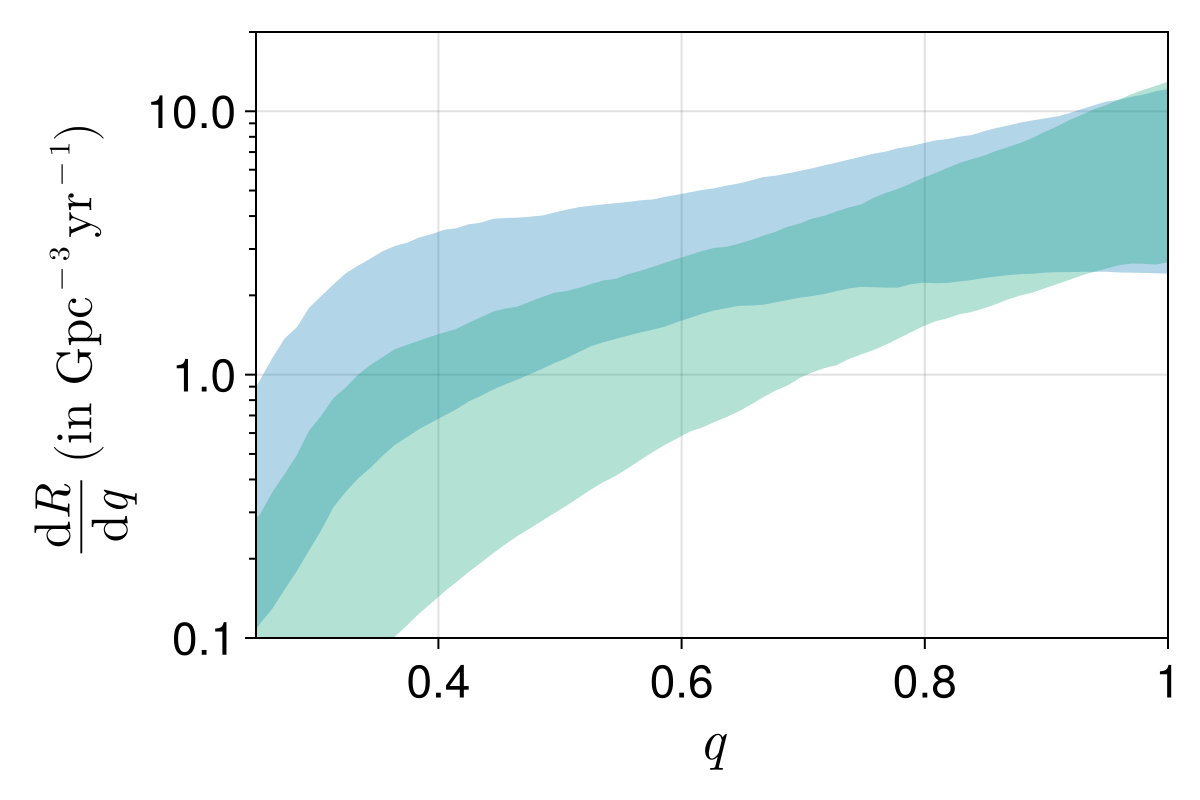

In [14]:
z_plot = 0.0
ms=exp.(log(m_bh_min):0.01:log(m_bh_max)) 
qs=collect(range(0.001, stop=1.0, length=100)) 
draws=draws
rng=Random.default_rng()
limits=(0.25, 1, 0.1, 20)
yticks=[0.1, 1, 10, 100]
yminorticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]
colors = Makie.wong_colors()
color_m1m2 = colors[1]  # blue
color_Mc = colors[3]  # orange


f = Figure(size=(600, 400))
    
a = Axis(f[1,1],
    xlabel = L"q",
    ylabel = L"\frac{\mathrm{d} R}{\mathrm{d} q}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    yscale = log10,
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    ytickformat = "{:.1f}",
    xtickformat = xs -> map(x -> isinteger(x) ? string(Int(x)) : string(round(x; digits=2)), xs),
    xticks = vcat(0.0:0.2:0.8, 1.0),
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = limits
)

# Plot m1-m2 Cut
trace = trace_m1m2
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_m1m2, 0.3), label=L"m_1-m_2~\mathrm{Cut}")

# Plot Mc Cut
trace = trace_Mc
p = trace.posterior
dNdq_matrix = zeros(length(qs), draws)

@progress for i in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdq = map(qs) do q
        integrand = map(ms) do m
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
            end
        end
        p.R[chain=c, draw=d] * trapz(ms, integrand)
    end

    dNdq_matrix[:, i] = dNdq
end

# Compute quantiles
q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

band!(a, qs, q5, q95, color=(color_Mc, 0.3), label=L"\mathrm{M}_\mathrm{c}~\mathrm{Cut}")
if plot_save
    save(outdir * "appen_diff_mcut_q_marginal.pdf", f, px_per_unit=3)
end
f

## Marginal $\chi_{\mathrm{eff}}$

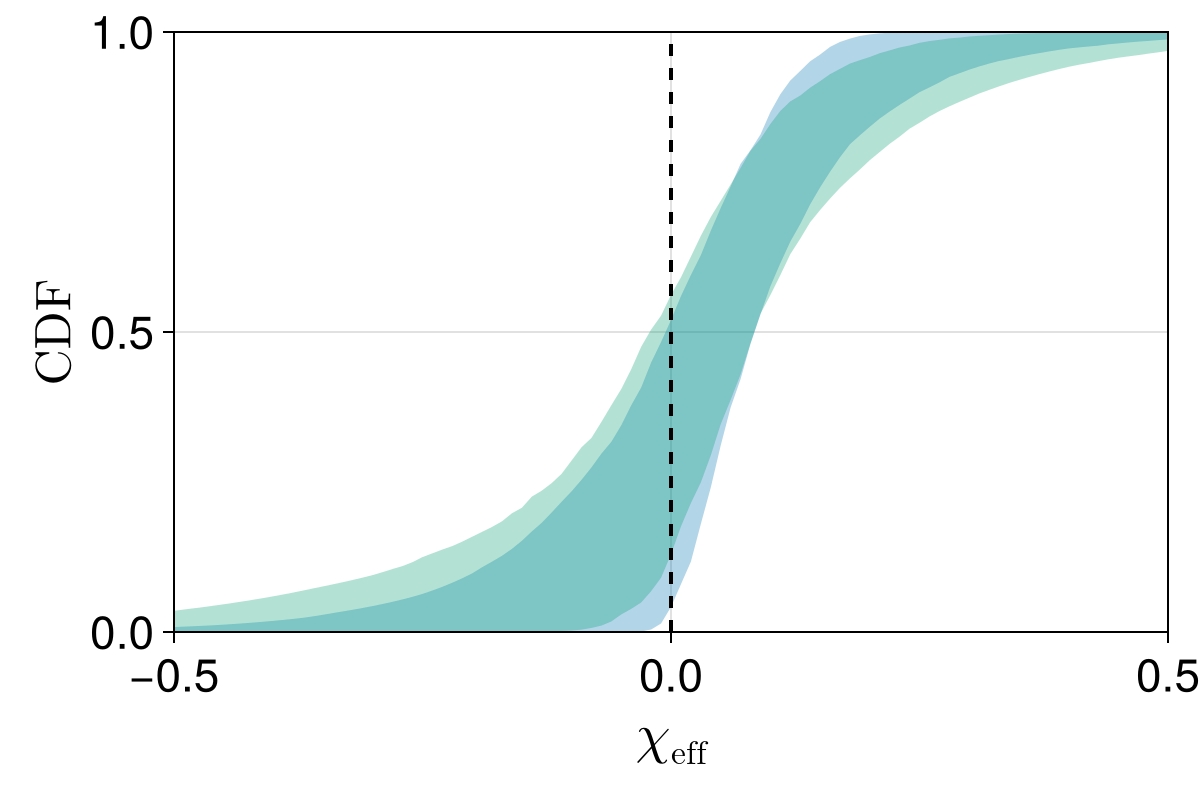

In [15]:
z_plot = 0.0
chi_effs = collect(-1.0:0.01:1.0)
qs = collect(0.01:0.01:1.0)
ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100))
draws = draws

colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_Mc = colors[3]

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\chi_\mathrm{eff}",
    ylabel=L"\mathrm{CDF}",
    xlabelsize=28, ylabelsize=25,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    xgridvisible=true, ygridvisible=true,
    limits = (-0.5, 0.5, 0.0, 1.0)
)

dchi_eff = chi_effs[2] - chi_effs[1]

# Plot m1 m2 Cut
trace = trace_m1m2
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_m1m2, 0.3), label=L"m_1-m_2~\mathrm{Cut}")

# Plot Mc Cut
trace = trace_Mc
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_Mc, 0.3), label=L"M_c~\mathrm{Cut}")

vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
if plot_save
    save(outdir * "appen_diff_mcut_chieff_marginal.pdf", fig, px_per_unit=3)
end
fig

## Marginal $z$

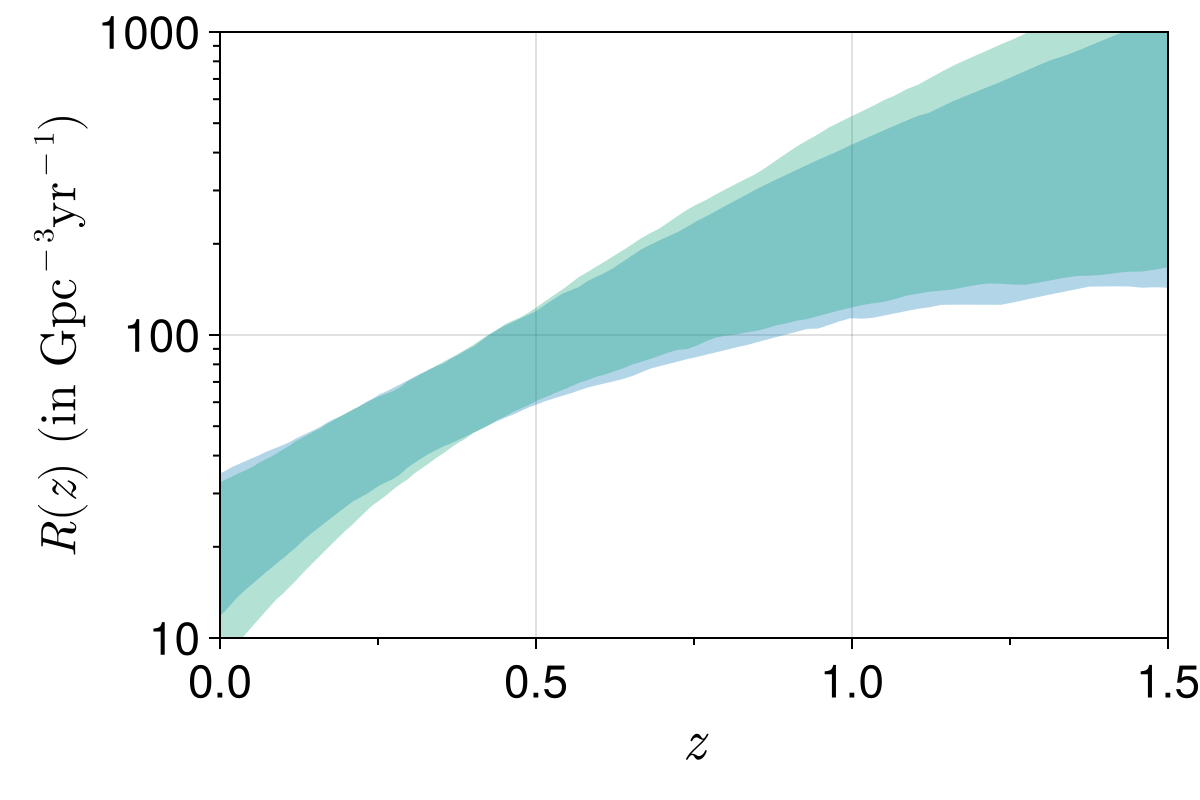

In [16]:
ms = exp.(log(m_bh_min):0.01:log(m_bh_max))
qs = 0.001:0.01:1
zs = expm1.(range(log(1), stop=log(1 + 2), length=128))
draws = draws
rng = Random.default_rng()
limits = (0, 1.5, 10, 1000)
yticks = [1, 10, 100, 1000]
yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900]

f = Figure(size=(600, 400))
a = Axis(f[1, 1],
    xlabel = L"z",
    ylabel = L"R(z)~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})",
    yscale = log10,
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    ytickformat = "{:.0f}",
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    xminorticksvisible = true,
    limits = limits
)

colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_Mc = colors[3]

# Plot m1 m2 Cut
trace = trace_m1m2
p = trace.posterior
dNs = zeros(length(zs), draws)

@progress for j in 1:draws
    c = rand(rng, span(dims(p, :chain)))
    d = rand(rng, span(dims(p, :draw)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    z1 = zs[1]
    dNdms = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
            end
        end
        trapz(qs, integrand)
    end

    norm = trace.posterior.R[draw=d, chain=c] *
            trapz(ms, dNdms) /
            exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

    dNdz = map(zs) do z
        norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
    end

    dNs[:, j] = dNdz
end

medians = mapslices(median, dNs; dims=2)[:]
lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

vs = vec(var(log.(dNs), dims=2))
imin = argmin(vs)
norm = Rz_med[imin]

band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(color_m1m2, 0.3), label=L"m_1-m_2~\mathrm{Cut}")

# Plot Mc Cut
trace = trace_Mc
p = trace.posterior
dNs = zeros(length(zs), draws)

@progress for j in 1:draws
    c = rand(rng, span(dims(p, :chain)))
    d = rand(rng, span(dims(p, :draw)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    z1 = zs[1]
    dNdms = map(ms) do m
        integrand = map(qs) do q
            m2 = q * m
            if m2 < m_bh_min
                zero(m)
            else
                exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
            end
        end
        trapz(qs, integrand)
    end

    norm = trace.posterior.R[draw=d, chain=c] *
            trapz(ms, dNdms) /
            exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

    dNdz = map(zs) do z
        norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
    end

    dNs[:, j] = dNdz
end

medians = mapslices(median, dNs; dims=2)[:]
lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

vs = vec(var(log.(dNs), dims=2))
imin = argmin(vs)
norm = Rz_med[imin]

band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(color_Mc, 0.3), label=L"M_c~\mathrm{Cut}")

if plot_save
    save(outdir * "appen_diff_mcut_z_marginal.pdf", f, px_per_unit=3)
end
f

## Comparison Plots

## Effective Spin

Contents of the file:
["Rchieff5", "Rchieff95", "chieff"]


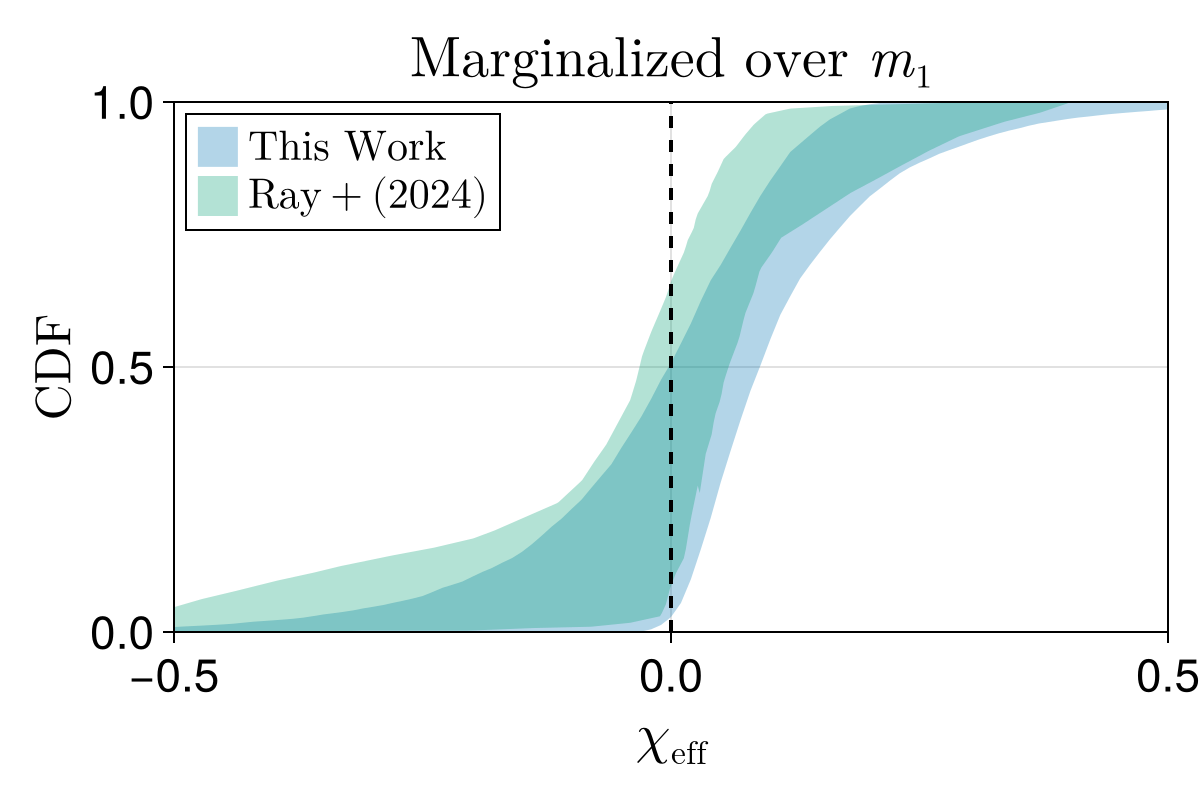

In [17]:
# with Ray et al. 2024 (https://arxiv.org/abs/2404.03166)

chieff_bgp, Rchieff95_bgp, Rchieff5_bgp = h5open("../data/anarya_data.h5", "r") do file
    println("Contents of the file:")
    println(keys(file))

    chieff_tmp = read(file["chieff"])
    R95_tmp = read(file["Rchieff95"])
    R5_tmp = read(file["Rchieff5"])

    return chieff_tmp, R95_tmp, R5_tmp
end

z_plot = 0.0
chi_effs = collect(-1.0:0.01:1.0)
qs = collect(0.01:0.01:1.0)
ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100))
draws = draws

colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_bgp = colors[3]
color_kde = colors[4]

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\chi_\mathrm{eff}",
    ylabel=L"\mathrm{CDF}",
    title=L"\mathrm{Marginalized~over}~m_1", titlesize=28,
    xlabelsize=28, ylabelsize=25,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    xgridvisible=true, ygridvisible=true,
    limits = (-0.5, 0.5, 0.0, 1.0)
)

dchi_eff = chi_effs[2] - chi_effs[1]

# Plot m1 m2 Cut
trace = trace_m1m2
p = trace.posterior
dNdchi_samples = []

for _ in 1:1000
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_m1m2, 0.3), label=L"\mathrm{This~Work}")

band!(ax, chieff_bgp, Rchieff5_bgp, Rchieff95_bgp, color=(color_bgp, 0.3), label=L"\mathrm{Ray+(2024)}")
axislegend(ax, position = :lt, labelsize = 21, framevisible = true)

vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
if plot_save
    save(outdir * "appen_comp_chieff_marginal.pdf", fig, px_per_unit=3)
end
fig

Contents of the file:
["Rchieff5", "Rchieff95", "chieff"]


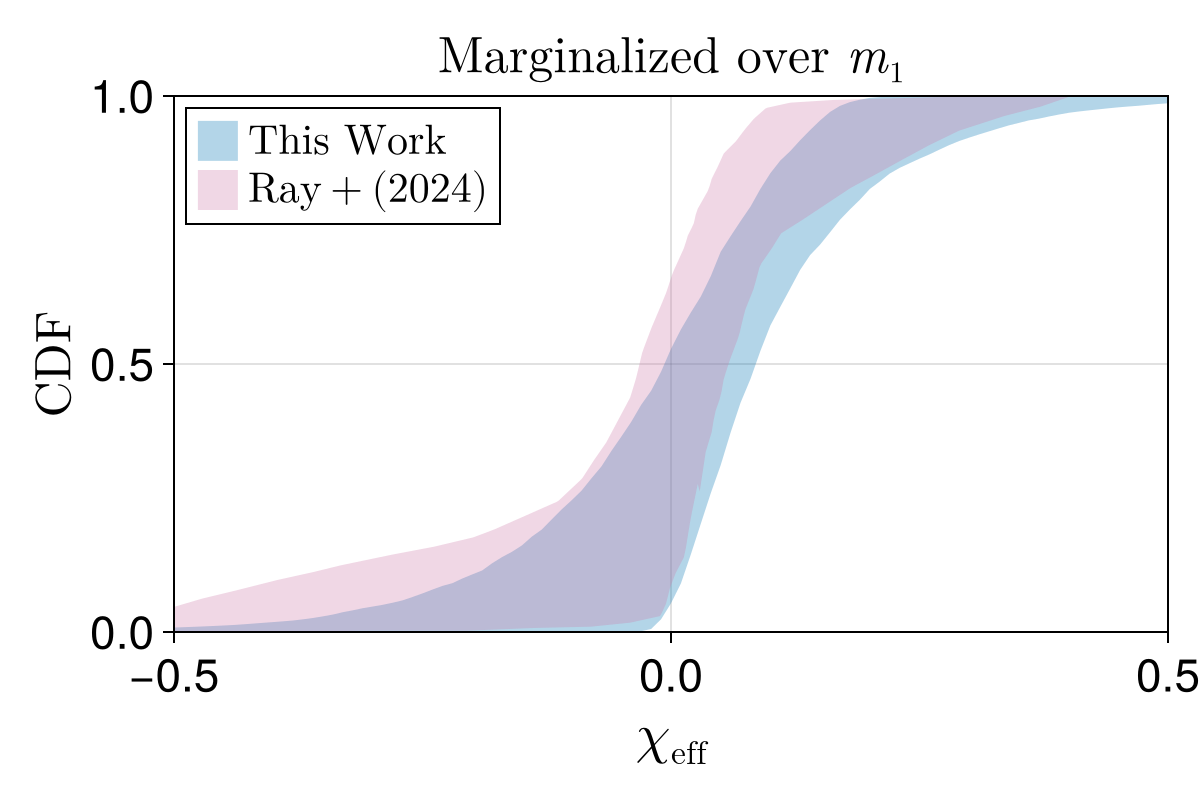

In [18]:
# with Ray et al. 2024 (https://arxiv.org/abs/2404.03166)

chieff_bgp, Rchieff95_bgp, Rchieff5_bgp = h5open("../data/anarya_data.h5", "r") do file
    println("Contents of the file:")
    println(keys(file))

    chieff_tmp = read(file["chieff"])
    R95_tmp = read(file["Rchieff95"])
    R5_tmp = read(file["Rchieff5"])

    return chieff_tmp, R95_tmp, R5_tmp
end

z_plot = 0.0
chi_effs = collect(-1.0:0.01:1.0)
qs = collect(0.01:0.01:1.0)
ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100))
draws = draws

colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_Mc = colors[3]
color_bgp = colors[4]  # green

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\chi_\mathrm{eff}",
    ylabel=L"\mathrm{CDF}",
    xlabelsize=28, ylabelsize=25,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    titlesize = 25, title=L"\mathrm{Marginalized~over~} m_1",
    xgridvisible=true, ygridvisible=true,
    limits = (-0.5, 0.5, 0.0, 1.0)
)

dchi_eff = chi_effs[2] - chi_effs[1]

# Plot m1 m2 Cut
trace = trace_m1m2
p = trace.posterior
dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        m_integrand = map(ms) do m
            q_integrand = map(qs) do q
                m2 = q*m
                if m2 < m_bh_min
                    0.0
                else
                    exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                end
            end
            trapz(qs, q_integrand)
        end
        p.R[draw=d, chain=c] * trapz(ms, m_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]  # normalize
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5    = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95    = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

b = band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_m1m2, 0.3), label=L"\mathrm{This~Work}")

b = band!(ax, chieff_bgp, Rchieff5_bgp, Rchieff95_bgp, color=(color_bgp, 0.3), label=L"\mathrm{Ray+(2024)}")

axislegend(ax, position = :lt, labelsize = 21, framevisible = true)  # top-right inside the plot
if plot_save
    save(outdir * "appen_comp_chieff_marginal.pdf", fig, px_per_unit=3)
end
fig

Contents of the file:
["cdf_5", "cdf_95", "chieff"]


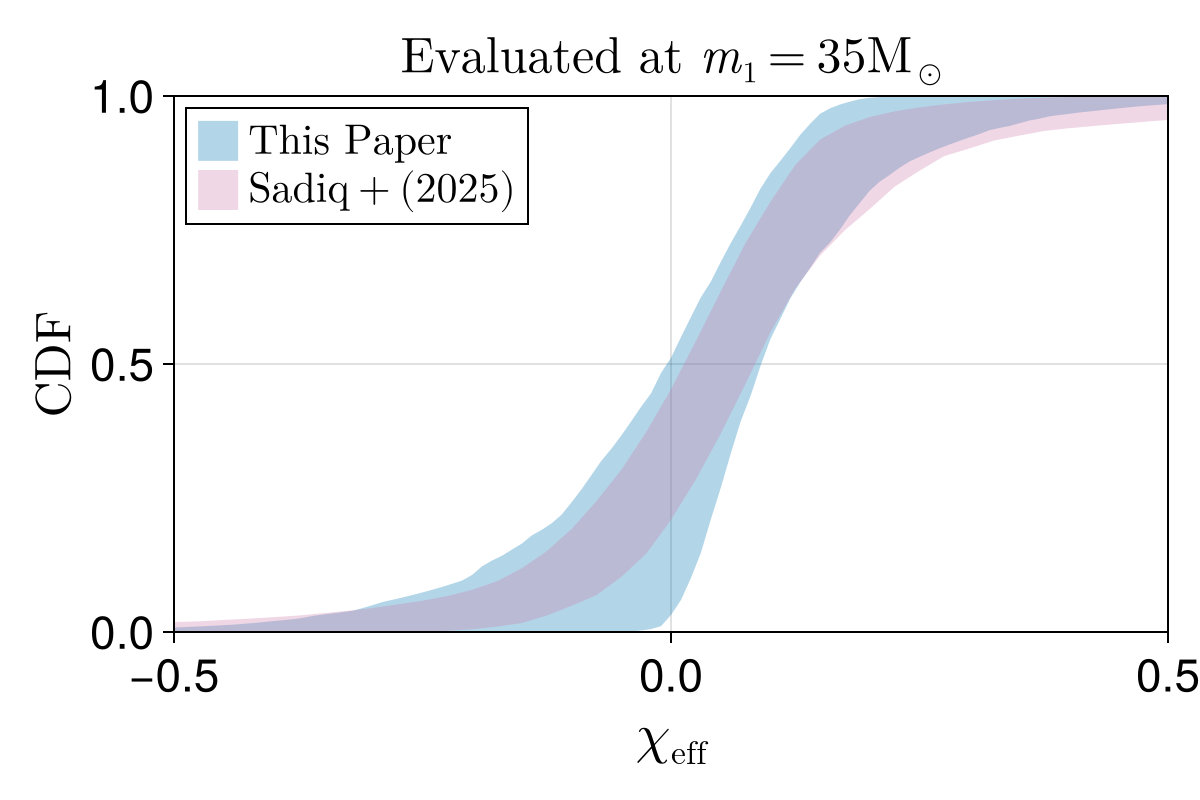

In [19]:
# with Sadiq et al. 2025 (https://arxiv.org/abs/2506.02250)

chieff_kde, Rchieff95_kde, Rchieff5_kde = h5open("../data/sadiq_data.h5", "r") do file
    println("Contents of the file:")
    println(keys(file))

    chieff_tmp = read(file["chieff"])
    cdf95_tmp = read(file["cdf_95"])
    cdf5_tmp = read(file["cdf_5"])

    return chieff_tmp, cdf95_tmp, cdf5_tmp
end

z_plot = 0.0
chi_effs = collect(-1.0:0.01:1.0)
qs = collect(0.01:0.01:1.0)
m_fixed = 35.0
draws = draws
rng = Random.default_rng()

colors = Makie.wong_colors()
color_m1m2 = colors[1]
color_kde = colors[4]

trace = trace_m1m2
p = trace.posterior

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\chi_\mathrm{eff}",
    ylabel=L"\mathrm{CDF}",
    xlabelsize=28, ylabelsize=25,
    xticklabelsize=xticklabelsize, yticklabelsize=yticklabelsize,
    titlesize=25, title=L"\mathrm{Evaluated~at~} m_1=35\mathrm{M}_{\odot}",
    xgridvisible=true, ygridvisible=true,
    limits = (-0.5, 0.5, 0.0, 1.0)
)

dNdchi_samples = []

for _ in 1:draws
    d = rand(rng, span(dims(p, :draw)))
    c = rand(rng, span(dims(p, :chain)))
    log_dN = log_dN_from_chain_sample(trace, d, c)

    dNdchi = map(chi_effs) do chi_eff
        q_integrand = map(qs) do q
            m2 = q * m_fixed
            if m2 < m_bh_min
                0.0
            else
                exp(log_dN(m_fixed, q, chi_eff, z_plot, 0.0))
            end
        end
        p.R[draw=d, chain=c] * trapz(qs, q_integrand)
    end

    cdf = cumsum(dNdchi)
    cdf ./= cdf[end]
    push!(dNdchi_samples, cdf)
end

cdf_matrix = reduce(hcat, dNdchi_samples)
cdf_p5  = mapslices(x -> quantile(x, 0.05), cdf_matrix; dims=2)[:]
cdf_p95 = mapslices(x -> quantile(x, 0.95), cdf_matrix; dims=2)[:]

band!(ax, chi_effs, cdf_p5, cdf_p95, color=(color_m1m2, 0.3), label=L"\mathrm{This~Paper}")
band!(ax, chieff_kde, Rchieff5_kde, Rchieff95_kde, color=(color_kde, 0.3), label=L"\mathrm{Sadiq+(2025)}")
axislegend(ax, position = :lt, labelsize = 21, framevisible = true)

if plot_save
    save(outdir * "appen_comp1_chieff_marginal.pdf", fig, px_per_unit=3)
end
fig